# Table of Contents

- [Introduction](#introduction)
- [Data Cleaning](#data-cleaning)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Hypothesis Testing](#hypothesis-testing)
- [Chi-Square Test of Independence](#chi-square-test-of-independence)
- [Two-Proportion Z-Test](#two-proportion-z-test-function)
- [Conclusion](#conclusion)

# Introduction

- **Purpose:** A startup in Germany is evaluating whether a redesigned landing page can increase its click-through rate (CTR). The new design aims to create a more engaging experience that encourages more visitors to click through and join the platform. After running the experiment for several weeks, the goal is to determine whether the observed uplift in CTR is statistically significant or simply due to random variation. This analysis validates whether the redesign produces a real improvement before rolling it out to all users.

 - **Data Overview:**

    The dataset contains three variables that help us analyze click-through rate (CTR) across different landing-page versions.
    
    **`treatment`**  
    Indicates whether the user saw the control page or the redesigned treatment page.  
    **Values:** `no` (control), `yes` (treatment)
    
    **`new_images`**  
    Shows whether the page included new images or the old ones.  
    **Values:** `no` (old images), `yes` (new images)
    
    **`converted`**  
    Represents whether the user clicked through the page (CTR).  
    **Values:** `1` (clicked), `0` (not clicked)

   ---

In [40]:
# Importing all the necessary python libraries for analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2

In [ ]:
# Importing the dataset

data = pd.read_csv(r"data/redesign.csv")

In [42]:
data.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


# Data Cleaning
Here we prepare the dataset for analysis by:
- Fixing incorrect data types
- Identifying and handling null values  
- Remove duplicates and outliers  
- Standardize column formats  
- Ensure overall data quality  

## Checking for Correct Data Types

Before analysis, it is important to verify that each column has the appropriate data type. Correct dtypes ensure accurate calculations, proper memory usage, and correct behavior of statistical tests. In this step, we confirm whether numerical, categorical, and boolean fields are stored in their expected formats.

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


<br>

The `treatment` and `new_images` columns are currently stored as `object` types. Since these variables represent discrete groups rather than free text, 
converting them to the `category` datatype reduces memory usage and makes operations such as grouping and comparisons more efficient.

<br>

In [44]:
# Converting object data type to category

data['treatment'] = data['treatment'].astype("category")
data['new_images'] = data['new_images'].astype("category")

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   treatment   40484 non-null  category
 1   new_images  40484 non-null  category
 2   converted   40484 non-null  int64   
dtypes: category(2), int64(1)
memory usage: 395.7 KB


## Checking for Missing Values

Before proceeding with analysis, it is important to understand if the dataset contains missing or null values. Missing data can affect statistical calculations and model performance. Here, we inspect each column to determine the presence and extent of missing values so we can choose an appropriate cleaning strategy.


In [46]:
# Checking for null values

data.isna().sum()

treatment     0
new_images    0
converted     0
dtype: int64

The dataset does not contain any missing or null values in any column. This means we can proceed with further analysis without performing imputation or removal of rows due to missing data.

## Checking for Inconsistencies in Data

In this step, we examine the dataset for inconsistent or incorrect entries such as invalid values, unexpected categories or mismatched labels. Identifying these issues early ensures that the analysis remains accurate and reliable.


In [47]:
# Checking for inconsistensies in columns

print(data['treatment'].value_counts())
print('')
print(data['new_images'].value_counts())
print('')
print(data['converted'].value_counts())

treatment
no     20242
yes    20242
Name: count, dtype: int64

new_images
no     20242
yes    20242
Name: count, dtype: int64

converted
0    35895
1     4589
Name: count, dtype: int64


None of the columns contain invalid, unexpected, or misspelled values.  
This indicates that the dataset is consistent and clean, allowing us to proceed confidently with further analysis.

## Creating Experimental Groups Based on Factor Combinations

The experiment contains two factors — `treatment` and `new_images` — each with “yes/no” values.  
To simplify analysis, we create a new column `group` that assigns each user to a specific experimental group based on the combination of these two factors.

This allows us to define four groups:
- **Control:** No treatment and no new images  
- **A:** New images only  
- **B:** Treatment only  
- **C:** Both treatment and new images  

Using `np.select()`, we map each condition to a corresponding group label, making the dataset easier to analyze for A/B and factorial testing.


In [48]:
# Creating a new columns 'group' that assigns experimental group based on the two factors i.e. 'treatment' and 'new_images'

conditions = [
    (data['treatment'] == 'no') & (data['new_images'] == 'no'),
    (data['treatment'] == 'no') & (data['new_images'] == 'yes'),
    (data['treatment'] == 'yes') & (data['new_images'] == 'no'),
    (data['treatment'] == 'yes') & (data['new_images'] == 'yes')
]

choices = ['Control', 'A', 'B', 'C']

data['group'] = np.select(conditions, choices, default = 'Unknown')

In [49]:
# Converting newly created 'group' columns to category data type with a specfic order of experimental groups

order = ['Control','A','B','C']
data['group'] = pd.Categorical(data['group'], categories=order, ordered=True)

In [50]:
# Dataset after cleaning

data.head(10)

,treatment,new_images,converted,group
0,yes,yes,0,C
1,yes,yes,0,C
2,yes,yes,0,C
3,yes,no,0,B
4,no,yes,0,A
5,yes,no,0,B
6,no,yes,0,A
7,no,no,0,Control
8,no,no,1,Control
9,no,yes,0,A


# Exploratory Data Analysis

To understand how each experimental group behaves, we generate descriptive statistics grouped by the group variable created earlier.

In [51]:
data.groupby('group', observed = True).describe()

converted                                             
            count      mean       std  min  25%  50%  75%  max
group                                                         
Control   10121.0  0.107104  0.309261  0.0  0.0  0.0  0.0  1.0
A         10121.0  0.112538  0.316043  0.0  0.0  0.0  0.0  1.0
B         10121.0  0.120047  0.325033  0.0  0.0  0.0  0.0  1.0
C         10121.0  0.113724  0.317491  0.0  0.0  0.0  0.0  1.0

All groups have the same sample size **(10,121 users)**, indicating a perfectly balanced experiment.

C:\Users\Rushikesh\AppData\Local\Temp\ipykernel_7316\1569884824.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='group', palette = palette)


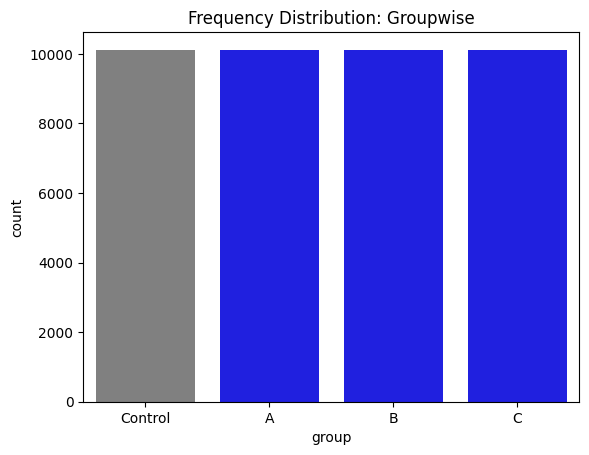

In [52]:
palette = ['grey','blue', 'blue', 'blue']
sns.countplot(data=data,x='group', palette = palette)
plt.title("Frequency Distribution: Groupwise")
plt.show()

In [53]:
data.groupby('group', observed = True)['converted'].mean().mul(100).reset_index()

,group,converted
0,Control,10.710404
1,A,11.253829
2,B,12.004743
3,C,11.372394


The mean conversion rates are:
- **Control: 10.71%**
- **A: 11.25%**
- **B: 12.00%**
- **C: 11.37%**

This suggests:
**Group B** appears to have the highest CTR.
All other groups **(Control, A, C)** have CTR relatively close to one another.

C:\Users\Rushikesh\AppData\Local\Temp\ipykernel_7316\2498526885.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = data, x = 'group', y = 'converted', errorbar = None, palette = palette)


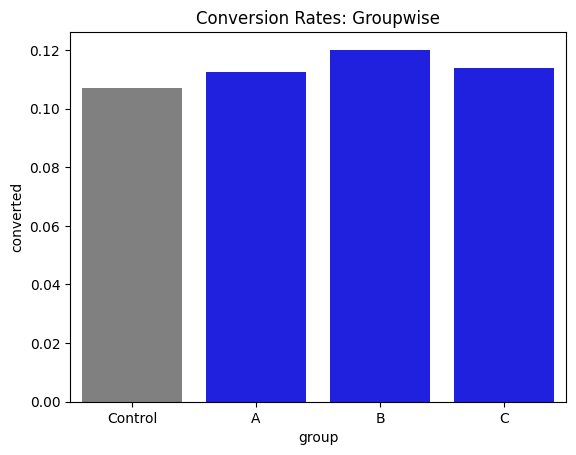

In [54]:
sns.barplot(data = data, x = 'group', y = 'converted', errorbar = None, palette = palette)
plt.title("Conversion Rates: Groupwise")
plt.show()

---

# Hypothesis Testing

Although the descriptive statistics show that **Group B** currently has the highest CTR, these differences in means could simply be due to random chance. 
To determine whether the improvement in Group B is real and not just a result of natural variability in user behavior, we perform formal hypothesis testing.

Hypothesis testing allows us to:

- Check whether the observed difference in CTR between groups is statistically significant
- Determine whether Group B genuinely outperforms the Control group
- Quantify the strength of evidence using p-values and confidence intervals
- Avoid making decisions based solely on raw averages, which may be misleading

This step ensures that our conclusion is backed by statistical evidence rather than random fluctuations in the data.

---

# Chi-Square Test of Independence

In this experiment, both of our key variables are categorical:

**Group (Control, A, B, C)**

**Converted (0 = did not convert, 1 = converted)**

Because we want to check whether CTRs depends on the experimental group, we need a statistical test that can evaluate the relationship between two categorical variables. The Chi-Square Test of Independence is specifically designed for this purpose.

We use the chi-square test because:

 - converted is a binary outcome (categorical)
 - Experimental groups are categorical
 - To test whether the distribution of conversions differs across groups
 - Do not need assumptions of normality or equal variances
 - It works well with large sample sizes, which we have

If the chi-square result is statistically significant, it suggests that CTR outcomes are not independent of the group, meaning at least one group performs differently from the others.

This tells us whether the differences observed in CTR (especially Group B being highest) reflect a real effect or are simply due to chance.

### All Chi-Square Assumptions Are Satisfied

All the required assumptions for conducting the Chi-Square Test of Independence are met in this dataset:

- Both variables (`group` and `converted`) are categorical  
- Users are independently assigned to groups  
- Expected frequencies in every cell are well above 5 due to large sample sizes  
- The experiment uses randomized assignment  

Since all assumptions are satisfied, we can reliably proceed with the chi-square test.

---

## Experiment Design

This experiment follows a **2 × 2 factorial design** with two binary factors:

- **Factor 1: `treatment`**
  - `no` - no treatment applied  
  - `yes` - treatment applied  

- **Factor 2: `new_images`**
  - `no` - old images  
  - `yes` - new images  

Based on the combination of these two factors, users are randomly assigned to one of four groups:

- **Control:** `treatment = no`, `new_images = no`  
- **Group A:** `treatment = no`, `new_images = yes`  
- **Group B:** `treatment = yes`, `new_images = no`  
- **Group C:** `treatment = yes`, `new_images = yes`  

The **outcome variable** is:

- **`converted`**:  
  - `0` → user did not convert  
  - `1` → user converted  

Our **primary goal** is to check whether the **CTR** differs across these four groups, and in particular, whether the higher CTR observed in **Group B** is statistically significant or just due to random chance.

---

## Hypotheses (Chi-Square Test of Independence)

We test whether the **click-through rate (CTR)** is independent of the **experimental group**.

- **Null Hypothesis (H₀):**  
  click-through rate is same across all groups.
  **OR**
  The `group` and `converted` variables are **independent**.  

- **Alternative Hypothesis (H₁):**  
  At least one group has a different click-through rate.
  **OR**
  The `group` and `converted` variables are **not independent**.  

If we reject the null hypothesis, it indicates that **click-through rate depends on the experimental group**, and we can then further investigate which group(s) are driving the difference.

In [55]:
data.head(10)

,treatment,new_images,converted,group
0,yes,yes,0,C
1,yes,yes,0,C
2,yes,yes,0,C
3,yes,no,0,B
4,no,yes,0,A
5,yes,no,0,B
6,no,yes,0,A
7,no,no,0,Control
8,no,no,1,Control
9,no,yes,0,A


## Contingency Table

To perform the Chi-Square Test of Independence, we first construct a **contingency table** that summarizes the relationship between the two categorical variables:

- **Group** (Control, A, B, C)  
- **Converted** (0 = no, 1 = yes)  

The contingency table displays the **count of users** who converted and did not convert within each experimental group.  
This helps us understand the distribution of conversion outcomes across groups and serves as the input for the chi-square test.

In [56]:
# Creating a contingency table for analysis

contingency_tab = pd.crosstab(index = data['group'], columns = data['converted'])
contingency_tab

converted,0,1
group,,
Control,9037,1084
A,8982,1139
B,8906,1215
C,8970,1151


In [57]:
# Canducting the chi-square test 

chi2_stat, p, dof, expected = chi2_contingency(contingency_tab)

print("Chi-square statistic:", chi2_stat)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:\n", expected)

Chi-square statistic: 8.526056765102425
p-value: 0.03630328708083606
Degrees of freedom: 3
Expected counts:
 [[8973.75 1147.25]
 [8973.75 1147.25]
 [8973.75 1147.25]
 [8973.75 1147.25]]


In [58]:
# Comparing the calculated p-value with significance level

alpha = 0.05

if p < alpha:
    print("Reject H0: There is a significant difference between click-through rate across groups")
else:
    print("Fail to reject H0: No significant difference in click-through rate")

Reject H0: There is a significant difference between click-through rate across groups


### Chi-Square Test Result

The Chi-Square Test of Independence shows a **statistically significant association** between the experimental group and the click-through rate.

This means:
- The click-through rate is **not same** across all four groups.
- At least one group performs **significantly differently** from the others.
- The observed differences in CTR are **unlikely to be due to random chance**.

Since the p-value is below the conventional threshold (α = 0.05), we **reject the null hypothesis** and conclude that the experimental group has a meaningful impact on conversion behavior.

This result justifies conducting **post-hoc pairwise comparisons** to identify *which specific groups* differ from each other.

---

# Two Proportion Z-Test

After the chi-square test shows that conversion rates differ across the four groups, the next step is to identify **which specific groups differ**.  
Since our outcome variable (`converted`) is **binary (0/1)** and we are comparing **proportions between two groups at a time**, the appropriate statistical method is the **Two-Proportion Z-Test**.

We use this test because:

- It compares **conversion proportions** between two independent groups  
- It quantifies the difference and provides a **p-value**  
- It allows us to calculate **confidence intervals** around the difference in CTR  
- It is ideal for large samples, which we have (10,121 users per group)  
- It directly answers whether, for example, **Group B truly performs better than the Control group**

### Assumptions of the Two-Proportion Z-Test

1. **Binary outcome variable**  
   The dependent variable must represent two categories.  

2. **Independent observations**  
   Each user belongs to only one group, and user behavior does not influence others.  

3. **Large sample size (normal approximation)**  
   Both groups must have sufficiently many successes and failures

4. **Independent groups**  
   The groups being compared must be separate samples.  

Given the large sample size, binary outcome, random assignment, and independent groups, **all assumptions for the two-proportion z-test are fully satisfied**.  
Therefore, it is appropriate and statistically valid to proceed with pairwise proportion comparisons between groups.

---

## Experiment Design for Two-Proportion Z-Test

After establishing that the click-through rate depends on the experimental group using the Chi-Square Test of Independence, we now perform pairwise comparisons between specific groups.

Since our business question is directional: “Does a variant improve click-through rate compared to the Control?”, we use a one-tailed two-proportion z-test.

**Key Experimental Setup:**
 - Each user is randomly assigned to exactly one group (Control, A, B, or C).
 - The outcome variable converted is binary (0 = no, 1 = yes).

For the two-proportion z-test, we compare Control against each variant separately:

 **- Control vs Group A** \
 **- Control vs Group B** \
 **- Control vs Group C** 

**Hypothesis (One-Tailed)**

For each pairwise comparison, we test:

**Null Hypothesis (H₀):**
The variant does not have a higher click-through rate than Control

**Alternative Hypothesis (H₁):**
The variant's click-through rate is higher than Control

This reflects our goal:
To determine whether a variant provides a real and statistically significant uplift in click-through rate relative to the baseline (Control).

A positive z-statistic and a small one-tailed p-value indicate that the variant performs significantly better than Control.

---

In [59]:
#Separating the groups for two proportion test

Control = data[(data['treatment'] == 'no') & (data['new_images'] == 'no')]
A = data[(data['treatment'] == 'no') & (data['new_images'] == 'yes')]
B = data[(data['treatment'] == 'yes') & (data['new_images'] == 'no')]
C = data[(data['treatment'] == 'yes') & (data['new_images'] == 'yes')]

In [60]:
Control.head()

,treatment,new_images,converted,group
7,no,no,0,Control
8,no,no,1,Control
14,no,no,0,Control
18,no,no,0,Control
20,no,no,0,Control


In [61]:
# Creating a custom function to conduct two proportion z-test on passing control group and variation group as argument

def z_test_result(control, variation, alpha = 0.05):

    """
    Performs a one-tailed two-proportion z-test to check whether the 
    click-through rate of a variation group is higher than that of the control group.

    Parameters
    ----------
    control : pandas DataFrame
        Subset of the data belonging to the control group.
        Must contain a binary 'converted' column (0/1).

    variation : pandas DataFrame
        Subset of the data belonging to the variation group.
        Must contain a binary 'converted' column (0/1).

    alpha : float, optional (default = 0.05)
        Significance level used for hypothesis testing.

    Method
    ------
    - Calculates conversion counts and totals for both groups
    - Computes a one-tailed two-proportion z-test using statsmodels
    - Prints z-statistic, p-value, and interpretation of results

    Output
    ------
    Prints:
    - Conversion rates
    - Z-statistic
    - P-value
    - Decision based on alpha

    Purpose
    -------
    Used to determine whether the variation group has a significantly 
    higher click-through rate than the control group after a chi-square test 
    indicates overall differences among groups.
    """

    
    control_success = (control['converted'] == 1).sum()
    variation_success = (variation['converted'] == 1).sum()
    
    control_total = len(control)
    variation_total = len(variation)

    control_rate = control_success / control_total
    variation_rate = variation_success / variation_total

    count = [variation_success, control_success]
    n_obs = [variation_total, control_total]

    z_stat, p_val = proportions_ztest(count, n_obs, alternative = 'larger')

    print("------ Hypothesis Testing Result ------")
    print(f"Control Conversion Rate: {control_rate:.4f}")
    print(f"Variation Conversion Rate: {variation_rate:.4f}")
    print(f"Z-statistic: {z_stat:.3f}")
    print(f"P-value: {p_val:.3f}")

    if p_val < alpha:
        print(f"Reject Null Hypothesis (p < {alpha}) : The variant's click-through rate is higher than Control")
    else:
        print(f"Fail to Reject Null Hypothesis (p ≥ {alpha}) : The variant does not have a higher click-through rate than Control")

    print("------------------------------------\n")

In [62]:
z_test_result(Control,A)

------ Hypothesis Testing Result ------
Control Conversion Rate: 0.1071
Variation Conversion Rate: 0.1125
Z-statistic: 1.236
P-value: 0.108
Fail to Reject Null Hypothesis (p ≥ 0.05) : The variant does not have a higher click-through rate than Control
------------------------------------



In [63]:
z_test_result(Control,B)

------ Hypothesis Testing Result ------
Control Conversion Rate: 0.1071
Variation Conversion Rate: 0.1200
Z-statistic: 2.902
P-value: 0.002
Reject Null Hypothesis (p < 0.05) : The variant's click-through rate is higher than Control
------------------------------------



In [64]:
z_test_result(Control,C)

------ Hypothesis Testing Result ------
Control Conversion Rate: 0.1071
Variation Conversion Rate: 0.1137
Z-statistic: 1.503
P-value: 0.066
Fail to Reject Null Hypothesis (p ≥ 0.05) : The variant does not have a higher click-through rate than Control
------------------------------------



---

# Conclusion

The pairwise one-tailed two-proportion z-tests comparing each variation group to the Control group show the following:

- **Group B** demonstrates a statistically significant increase in click-through rate compared to the Control group.
This indicates that the uplift observed in Group B is unlikely to be due to random chance and represents a real improvement in performance.


- **Group A** does **not** show a statistically significant increase compared to the Control group.
Although its click-through rate is slightly higher than Control, the improvement is not strong enough to be considered statistically meaningful.


- **Group C** also does **not** show a statistically significant increase compared to the Control group.
The small rise in CTR does not provide enough evidence to conclude a true uplift.


Among all three variations, only **Group B** provides a statistically significant **increase** in click-through rate (CTR), while Groups A and C do not show meaningful uplift over the Control group.